In [1]:
from fastai.vision.all import *

from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path

np.random.seed(0)

In [2]:
path = Path('../2.4_Modify_Entire_Dataset/CheXpert-v1.0-small-MOD/')

In [3]:
df_mod = pd.read_csv('df_mod_pathadjusted.csv', index_col = 0)

In [4]:
df_mod.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,magnets,no_mod,bullet,coin
0,train/patient00001/study1/view1_frontal_mod_magnets.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,True,NaN,NaN,NaN
1,train/patient00002/study2/view1_frontal_mod_no_mod.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,True,NaN,NaN
2,train/patient00002/study1/view1_frontal_mod_no_mod.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
3,train/patient00002/study1/view2_lateral_mod_no_mod.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,NaN,NaN
4,train/patient00003/study1/view1_frontal_mod_bullet.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [5]:
files = get_image_files(path)
len(files)

178755

In [6]:
label_cols = 'coin magnets bullet no_mod'.split(' ')

In [7]:
label_cols

['coin', 'magnets', 'bullet', 'no_mod']

In [8]:
df_mod['label'] = df_mod[label_cols].fillna(0).astype('int').idxmax(axis = 1)

In [9]:
df = df_mod[['Path','label']]

In [15]:
df.iloc[:178000]

,Path,label
0,train/patient00001/study1/view1_frontal_mod_magnets.jpg,magnets
1,train/patient00002/study2/view1_frontal_mod_no_mod.jpg,no_mod
2,train/patient00002/study1/view1_frontal_mod_no_mod.jpg,no_mod
3,train/patient00002/study1/view2_lateral_mod_no_mod.jpg,no_mod
4,train/patient00003/study1/view1_frontal_mod_bullet.jpg,bullet
...,...,...
177995,train/patient41732/study3/view1_frontal_mod_bullet.jpg,bullet
177996,train/patient41733/study3/view1_frontal_mod_bullet.jpg,bullet
177997,train/patient41733/study1/view1_frontal_mod_no_mod.jpg,no_mod
177998,train/patient41733/study2/view1_frontal_mod_bullet.jpg,bullet


In [16]:
dls = ImageDataLoaders.from_df(df = df.iloc[:178000], path = path, item_tfms=Resize(224))

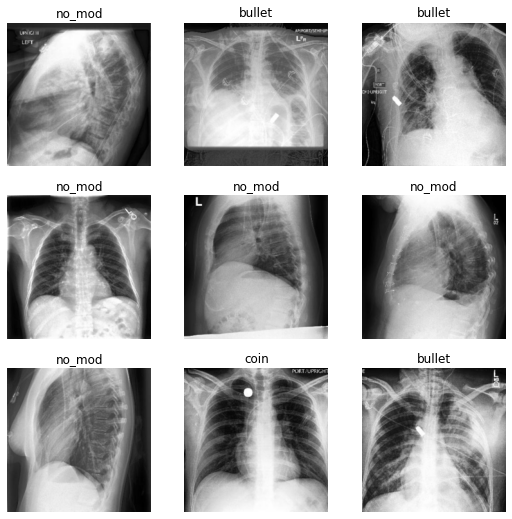

In [17]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, lr = 0.00524807)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
tta = learn.tta(use_max=True)

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
learn.save('20220426_model_binary_mod_nomod')

In [ ]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

In [ ]:
sensitivity = tp/(tp + fn)
sensitivity

**Specificity = True Negative/(False Positive + True Negative)**

In [ ]:
specificity = tn/(fp + tn)
specificity

The model has a specificity of 94% and hence can correctly detect 94% of the time that a patient does **not** have a coin in the trachea but will incorrectly classify that 6% of the patients have coin in the trachea (False Postive) but actually do not.

This is also known as a **Type I error**

**Positive Predictive Value (PPV)**

In [ ]:
ppv = tp/(tp+fp)
ppv

In this case the model performs well in correctly predicting patients with coin in the trachea.

**Negative Predictive Value (NPV)**

In [ ]:
npv = tn/(tn+fn)
npv